In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import os
from pathlib import Path
from skimage.color import rgb2gray
import matplotlib as mpl
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report

The image size is: (150, 150)


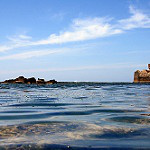

In [2]:
# opening image using open function of PIL package
image = Image.open('C:\\Users\\srini\\Downloads\\intel-image-classification\\seg_train\\seg_train\\sea\\687.jpg')

# image size
print('The image size is:', image.size)

# Seeing the image
image

In [10]:
# turning the image into a numpy array 
imgData = np.array(image)
print("image as array", imgData)

# checking the shape of the aaray
print('The shape of the array is:', imgData.shape)



image as array [[[100 154 226]
  [101 155 227]
  [102 156 228]
  ...
  [ 87 140 218]
  [ 88 139 218]
  [ 91 140 217]]

 [[102 156 228]
  [102 156 228]
  [103 157 229]
  ...
  [ 92 141 217]
  [ 95 143 219]
  [ 97 145 219]]

 [[105 157 230]
  [105 157 230]
  [106 158 231]
  ...
  [ 97 144 216]
  [100 147 219]
  [106 150 223]]

 ...

 [[ 62  73  75]
  [ 60  74  77]
  [ 67  81  84]
  ...
  [ 62  84 107]
  [ 62  84 107]
  [ 63  85 108]]

 [[ 51  69  73]
  [ 44  61  68]
  [ 37  54  62]
  ...
  [ 40  58  80]
  [ 39  57  79]
  [ 41  59  81]]

 [[ 44  61  71]
  [ 39  55  68]
  [ 31  47  60]
  ...
  [ 23  40  60]
  [ 22  39  59]
  [ 23  40  60]]]
The shape of the array is: (150, 150, 3)


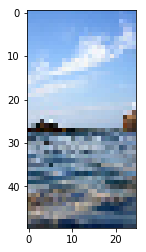

(50, 25, 3)

In [8]:
# resize the image for model
imgResize = np.array(image.resize((25,50)))
# plotting the data with imshow
plt.imshow(imgResize)
plt.show()

imgResize.shape

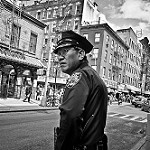

The shape of the array: (50, 25)


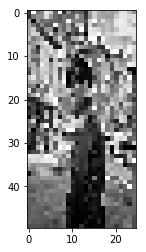

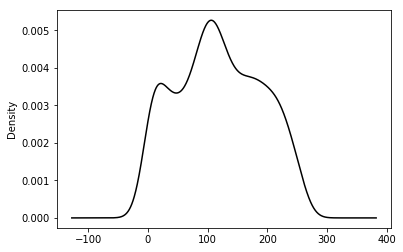

In [14]:
# converting image to grayscale
imgBW = img.convert('L')
display(imgBW)

# converting to the image to array
imgBWarr = np.array(imgBW.resize((25,50)))

# checking the shape
print('The shape of the array:', imgBWarr.shape)

# plotting the array using matplotlib
plt.imshow(imgBWarr, cmap=plt.cm.gray)
plt.show()

# checking plotKDE function by plotting kde of the new array
plotKDE(imgBWarr, 'k')

In [18]:
# defining labels as a dictionary
imageLabels = { 'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}

# defining labels as a dictionary (inverse)
imageLabelsInv = { 0:'buildings', 1:'forest', 2:'glacier', 3:'mountain', 4:'sea', 5:'street'}

labels = []

# looping over images in the folder (image classification data)
for folder in os.listdir(path):
    for file in os.listdir(Path(path, folder)):
        img = Image.open(Path(path, folder, file))
        #if np.array(img).shape == (150, 150, 3): 
        labels.append([(int(os.path.splitext(file)[0])), imageLabels.get(folder)])
        
labels = pd.DataFrame(labels, columns=['id','label'])
labels = labels.set_index('id')
labels.head()

,label
id,
0,0
10006,0
1001,0
10014,0
10018,0


In [19]:
# converting an image id into the numpy array of the corresponding image
def getIMG(rowId):
    folder = imageLabelsInv.get(labels.loc[rowId, 'label'])
    filename = '{}.jpg'.format(rowId)
    filepath = Path(path, folder, filename)
    img = Image.open(filepath)
    return np.array(img.resize((25,50)))

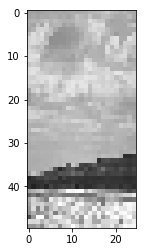

In [20]:
#  data from the tenth id in the sea images
seaID = labels[labels.label == 4].index[9]

plt.imshow(getIMG(seaID))
plt.show() 

In [21]:
# checking number of images per class
for i in range(6):
    print(i, labels[labels.label == i].size)

0 2191
1 2271
2 2404
3 2512
4 2274
5 2382


The color image has shape:  (50, 25, 3)
The gray image has shape:  (50, 25)


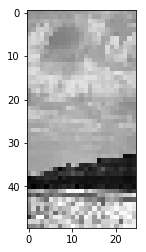

In [22]:
# sea image
sea = getIMG(seaID)

# shape of the sea image
print('The color image has shape: ', sea.shape)

# rgb2grey function to for converting the image to the greyscale
graySea = rgb2gray(sea)

# grey-scale image
plt.imshow(graySea, cmap=mpl.cm.gray)


# shape of grey image
print('The gray image has shape: ', graySea.shape)

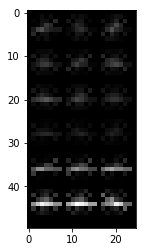

In [30]:
# using hog ( Histogram Over Gradient ) function to get the hog features of the grey image

hogFeatures, hogImage = hog(graySea, visualize=True, pixels_per_cell=(8,8), cells_per_block= (2,2))

# hog Image 
plt.imshow(hogImage, cmap=mpl.cm.gray)

In [31]:
def createFeatures(img):
    # flattening the colors of the image using img.flatten
    colorFeatures = img.flatten()
    
    # rgb2grey function to for converting the image to the greyscale
    grayImage = rgb2gray(img)
    
    # using hog function to get the hog features of the grey image
    hogFeatures = hog(grayImage, block_norm='L2-Hys', pixels_per_cell=(8,8))
    #combining the features
    flatFeatures = np.hstack((colorFeatures, hogFeatures))
    return flatFeatures
    
seaFeatures = createFeatures(sea)

# checking the shape of the matrix
print(seaFeatures.shape)

imageFeatures = seaFeatures

(4074,)


In [32]:
# function to create feature matrix
def createFM(df):
    featuresList = []
    
    for imgId in df.index:
        img = getIMG(imgId) #loading the image using our get image function
        # Get features for image
        imageFeatures = createFeatures(img).astype(np.float32)
        # Adding the features to the list
        featuresList.append(imageFeatures)

    # getting matrix from the list 
    featuresList = np.array(featuresList)
    return featuresList

# Testing the  function
featureMatrix = createFM(labels)

In [33]:
# checking shape of feature matrix
print('The shape of the feature matrix is:', featureMatrix.shape)



The shape of the feature matrix is: (14034, 4074)


In [34]:
# Initiating StandardScaler 
ss = StandardScaler()
# Apply the scaler
featureMtrix = ss.fit_transform(featureMatrix)

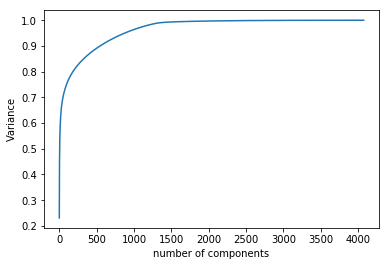

In [35]:
pca=PCA().fit(featureMatrix)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('Variance')
plt.show()

In [36]:
pca = PCA(n_components = 1800)
# using fit_transform to run PCA on our standardized matrix
featureMatrix = pca.fit_transform(featureMatrix)
# look at new shape
print('PCA matrix shape is: ', featureMatrix.shape)

PCA matrix shape is:  (14034, 1800)


In [37]:
y = labels.label.values
# train test split distribution of data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(featureMatrix, y, test_size=.3)


# checking at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

3    1743
5    1671
2    1652
1    1613
4    1601
0    1543
dtype: int64

In [38]:
# defining the support vector classifier
svm = SVC(kernel='linear', probability=True)

# fitting the model with train data
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [39]:
# generating predictions using svm predict
yPred = svm.predict(X_test)

# calculating accuracy using accuracy_score from svc 
accuracy = accuracy_score(y_test, yPred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.4155782474471622


In [46]:
classification_report(y_test, yPred)

'              precision    recall  f1-score   support\n\n           0       0.26      0.34      0.29       648\n           1       0.62      0.65      0.64       658\n           2       0.42      0.46      0.44       752\n           3       0.43      0.43      0.43       769\n           4       0.27      0.23      0.25       673\n           5       0.54      0.39      0.45       711\n\n   micro avg       0.42      0.42      0.42      4211\n   macro avg       0.42      0.42      0.42      4211\nweighted avg       0.42      0.42      0.42      4211\n'